In [1]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer, Trainer, TrainingArguments
import torch
from PIL import Image
import torch.nn as nn
import cv2
from torchvision import transforms
from tqdm.notebook import tqdm
# from ultralytics import YOLO
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam
import requests
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import json
import os
import pickle
import random

In [2]:

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

VisionEncoderDecoderModel has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Train

In [3]:
pip install transformers datasets torch torchvision -q

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


### Get data

In [4]:
# load features from pickle
with open(os.path.join('/kaggle/input/feature-10k/220k_GPT4_features_10000.pkl'), 'rb') as f:
  features = pickle.load(f)

/opt/conda/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [5]:
data = pd.read_parquet("hf://datasets/laion/220k-GPT4Vision-captions-from-LIVIS/lvis_caption_url.parquet")

In [6]:
urls = list(features.keys())
urls_set = set(urls)

# Lọc các dòng trong DataFrame dựa trên điều kiện 'url' trùng với danh sách urls
filtered_data = data[data['url'].isin(urls_set)]
filtered_data_unique = filtered_data.drop_duplicates(subset='url')

# Tạo DataFrame mới chỉ chứa cột 'url' và 'caption'
result = filtered_data_unique[['url', 'caption']]

# Lưu DataFrame này thành file CSV
# output_file = 'filtered_urls_captions.csv'
# result.to_csv(output_file, index=False)

In [7]:
# load caption
file_path = '/kaggle/input/dataset/filtered_urls_captions.csv'
captions = pd.read_csv(file_path)

In [8]:
# Chuyển ảnh về kích thước phù hợp với model
def convert_img_feature(features):
    if features.shape[1] != 3 or features.shape[2:] != (224, 224):
        features = torch.nn.functional.interpolate(features, size=(224, 224), mode='bilinear', align_corners=False)
        features = features[:, :3, :, :]  # Chỉ giữ 3 kênh đầu
    return features

# Quan sát kích thước

In [9]:
# import torch

# # Giả sử bạn có một tensor image với kích thước không đúng
# # Ví dụ: một tensor với kích thước (batch_size, channels, height, width)
# features = torch.randn(4, 256, 20, 20)  # 4 ảnh, 5 kênh, 256x256 pixels

# # Gọi hàm convert_img_feature để xử lý ảnh
# converted_features = convert_img_feature(features)

# # In kích thước của features sau khi chuyển đổi
# print(converted_features.shape)  # Kết quả mong đợi: (4, 3, 224, 224)

# ecd_feature = model.encoder(converted_features)
# # Kiểm tra kiểu của ecd_feature
# print("Kiểu của ecd_feature:", type(ecd_feature))

# # Truy xuất tensor từ đầu ra nếu cần thiết
# if hasattr(ecd_feature, 'last_hidden_state'):
#     print("Kích thước của last_hidden_state:", ecd_feature.last_hidden_state.shape)

# # Nếu đối tượng trả về có thuộc tính 'pooler_output'
# if hasattr(ecd_feature, 'pooler_output'):
#     print("Kích thước của pooler_output:", ecd_feature.pooler_output.shape)

In [10]:
# caption = "A man is playing guitar on stage"  # Ví dụ về caption của ảnh

# # Tokenize văn bản
# inputs = tokenizer(caption, padding="max_length", max_length=315, truncation=True)

# input_ids = torch.tensor(tokenized_caption["input_ids"])
# attention_mask = torch.tensor(tokenized_caption["attention_mask"])

# # In ra kích thước của các tensor trong dictionary inputs
# print(f"Input IDs size: {input_ids.shape}")
# print(f"Attention mask size: {attention_mask.shape}")
# print(input_ids)

## Chia train, val, test

In [11]:

# # Chuyển urls_set thành danh sách để thao tác
# urls_list = list(urls_set)

# # Cố định tập test
# test_size = int(0.1 * len(urls_list))
# random.seed(42)
# test_urls = random.sample(urls_list, test_size)

# # Lấy phần còn lại làm train + val ban đầu
# train_val_urls = list(set(urls_list) - set(test_urls))

# # Lưu test_urls vào CSV
# test_df = pd.DataFrame(test_urls, columns=["url"])
# test_csv_path = "test_urls.csv"
# test_df.to_csv(test_csv_path, index=False)

# # Lưu train_val_urls vào CSV
# train_val_df = pd.DataFrame(train_val_urls, columns=["url"])
# train_val_csv_path = "train_val_urls.csv"
# train_val_df.to_csv(train_val_csv_path, index=False)

In [12]:
# Hàm chia train-val ngẫu nhiên sau mỗi epoch
def shuffle_train_val(train_val_urls, train_ratio=8/9):
    random.shuffle(train_val_urls)
    train_size = int(train_ratio * len(train_val_urls))
    train_urls = train_val_urls[:train_size]
    val_urls = train_val_urls[train_size:]
    return train_urls, val_urls

In [13]:
# Đọc file test_urls.csv và chuyển về list
test_csv_path = "/kaggle/input/dataset/test_urls.csv"
test_df = pd.read_csv(test_csv_path)
test_urls = test_df["url"].tolist()

# Đọc file train_val_urls.csv và chuyển về list
train_val_csv_path = "/kaggle/input/dataset/train_val_urls.csv"
train_val_df = pd.read_csv(train_val_csv_path)
train_val_urls = train_val_df["url"].tolist()

# Chuyển về set nếu cần thiết
test_urls = list(test_urls)
train_val_urls_set = list(train_val_urls)

In [14]:
# Ví dụ huấn luyện qua nhiều epoch
train_urls, val_urls = shuffle_train_val(train_val_urls_set)

In [15]:
a=0
for url in train_urls:
    print(url)
    print(features[url].size())
    print(convert_img_feature(features[url]).size())
    print(captions['caption'][captions.url==url].values[0])
    if a == 1:
        break
    a = 1

http://images.cocodataset.org/train2017/000000450391.jpg
torch.Size([1, 256, 20, 20])
torch.Size([1, 3, 224, 224])
a workspace with a computer monitor, a computer keyboard, a water bottle, a telephone, a speaker, a remote control, and a desk. The water bottle is red and metallic, possibly made of stainless steel. The computer keyboard is positioned to the right of the water bottle. There are six electronic devices in the image, including a computer monitor, a computer keyboard, a telephone, a speaker, and a remote control.
http://images.cocodataset.org/train2017/000000370503.jpg
torch.Size([1, 256, 20, 20])
torch.Size([1, 3, 224, 224])
a close-up perspective of someone riding a skateboard on a road during sunset or sunrise. The skateboarder's leg and foot, the skateboard wheels, and the road in motion are visible. There are trees and utility poles in the background, and the sky is painted with hues of pink and purple. The skateboarder is wearing a watch on their wrist. The environment 

## Test Yolo

In [16]:
pip install ultralytics -q

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [17]:
from ultralytics.nn.tasks import DetectionModel
from ultralytics.nn.tasks import attempt_load_one_weight

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [18]:
import torch
import ultralytics
from ultralytics import YOLO

print(ultralytics.__version__)

# Load the YOLOv8 model
model_yolo = YOLO('yolov8n.pt')

# Access the backbone layers
backbone = model_yolo.model.model[:10]  # Layers 0 to 9 form the backbone

# Create a new Sequential model with just the backbone layers
backbone_model = torch.nn.Sequential(*backbone)

8.3.39


In [19]:
class FeatureExtractorModel(nn.Module):
    def __init__(self, backbone_model):
        super(FeatureExtractorModel, self).__init__()
        self.backbone_model = backbone_model
        self.preprocess = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((640, 640)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def preprocess_image(self, image):
        tensor_image = self.preprocess(image).unsqueeze(0)  # Thêm batch dimension
        return tensor_image

    def forward(self, image):
        # Tiền xử lý ảnh
        image_tensor = self.preprocess_image(image)

        # Trích xuất đặc trưng với backbone model
        with torch.no_grad():
            features = self.backbone_model(image_tensor)
        
        # Kiểm tra và điều chỉnh kích thước đầu ra của features
        if features.shape[1] != 3 or features.shape[2:] != (224, 224):
            features = torch.nn.functional.interpolate(features, size=(224, 224), mode='bilinear', align_corners=False)
            features = features[:, :3, :, :]  # Chỉ giữ 3 kênh đầu

        return features

# Sử dụng FeatureExtractorModel để trích xuất đặc trưng từ ảnh
feature_extractor = FeatureExtractorModel(backbone_model)

In [20]:
# In ra cấu trúc của encoder (Yolov8)
print("Encoder (Yolov8) Summary:")
print(feature_extractor)

Encoder (Yolov8) Summary:
FeatureExtractorModel(
  (backbone_model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
    

In [21]:
def caption_preprocess(caption):
    # convert to lowercase
    caption = caption.lower()
    # delete digits, special  chars, etc, ..
    caption = caption.replace('[^A-Za-z]', '')
    # delete additional spaces
    caption = caption.replace('\s+', ' ')
    return caption

In [22]:
from transformers import default_data_collator
from torch.utils.data import DataLoader, Subset

# Hàm để xử lý từng ảnh và caption
def process_data(url):
    try:
        # Sử dụng FeatureExtractorModel để trích xuất đặc trưng
        pixel_values = convert_img_feature(features[url]).squeeze()
        # Tiền xử lý caption
        # Tiền xử lý caption
        caption_series = captions['caption'][captions.url == url]
        if caption_series.empty:  # Kiểm tra nếu không có dữ liệu
            raise ValueError(f"Không tìm thấy caption cho URL: {url}")
        
        caption = caption_series.iloc[0]
        caption = caption_preprocess(caption)
        
        # Tokenize caption
        tokenized_caption = tokenizer(caption, padding="max_length", max_length=315, truncation=True)
        
        # Trích xuất input_ids và attention_mask
        input_ids = torch.tensor(tokenized_caption["input_ids"])
        attention_mask = torch.tensor(tokenized_caption["attention_mask"])
        
        return {
            "pixel_values": pixel_values,
            "input_ids": input_ids,
            "attention_mask": attention_mask
        }
    except Exception as e:
        print(f"Error processing data: {e}")
        return None  # Hoặc giá trị mặc định

# Dataset class
class ImageCaptionDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        data = process_data(self.image_paths[idx])
        if data is None:  # Nếu ảnh bị lỗi, bỏ qua
            return self.__getitem__((idx + 1) % len(self))
        return data

# Collate function tùy chỉnh
def custom_collate_fn(batch):
    batch = [item for item in batch if item is not None]  # Bỏ các phần tử lỗi
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    input_ids = torch.stack([item["input_ids"] for item in batch])
    attention_mask = torch.stack([item["attention_mask"] for item in batch])
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask
    }

# Tạo dataset cho từng tập dữ liệu
train_dataset = ImageCaptionDataset(train_urls)
val_dataset = ImageCaptionDataset(val_urls)
test_dataset = ImageCaptionDataset(test_urls)

# Tạo DataLoader cho train, val, test
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=custom_collate_fn)


In [23]:
from transformers import AutoModelForVision2Seq

# Đường dẫn thư mục chứa các tệp mô hình
model_path = '/kaggle/input/yolov8_gpt2_v20ep/pytorch/default/1'

# Tải mô hình VisionEncoderDecoder
model = AutoModelForVision2Seq.from_pretrained(model_path)

In [24]:
# # In ra cấu trúc của decoder (GPT-2)
# print("\nDecoder (GPT-2) Summary:")
print(model)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [25]:
from torch.optim import AdamW
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Cấu hình optimizer
optimizer = AdamW(model.parameters(), lr=3e-5)

# Hàm huấn luyện
def train_model(model, train_dataloader, val_dataloader, optimizer, epochs=1):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_dataloader:
            # Load batch vào thiết bị
            pixel_values = batch["pixel_values"].to(device)
            print(pixel_values.shape)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            # Forward pass qua encoder
            encoder_outputs = model.encoder(pixel_values=pixel_values)

            # Forward pass qua decoder
            # outputs = model(pixel_values=pixel_values, labels=input_ids)
            outputs = model.decoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                encoder_hidden_states=encoder_outputs.last_hidden_state,
                labels=input_ids
            )
            loss = outputs.loss
            total_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_dataloader)}")
        # Đánh giá trên tập validation sau mỗi epoch
        evaluate_model(model, val_dataloader)

    # Lưu mô hình sau khi huấn luyện
    save_path = '/kaggle/working/outputv25/'
    model.save_pretrained(save_path)
    print(f"Model saved to {save_path}")

def evaluate_model(model, val_dataloader):
    model.eval()  # Đặt mô hình ở chế độ đánh giá
    total_val_loss = 0
    with torch.no_grad():  # Tắt gradient để không tính toán lại trong quá trình đánh giá
        for batch in val_dataloader:
            # Load batch vào thiết bị
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            
            # Forward pass qua encoder
            encoder_outputs = model.encoder(pixel_values=pixel_values)

            # Forward pass qua decoder
            outputs = model.decoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                encoder_hidden_states=encoder_outputs.last_hidden_state,
                labels=input_ids  # Đặt labels là input_ids
            )
            val_loss = outputs.loss
            total_val_loss += val_loss.item()

    print(f"Validation Loss: {total_val_loss/len(val_dataloader)}")

In [26]:
# Huấn luyện mô hình
# train_model(model, train_dataloader, val_dataloader, optimizer)

In [27]:
# Epoch 1, Loss: 0.802893521592021
# Validation Loss: 0.7059373706579208

# Epoch 2, Loss: 0.7060485577285289
# Validation Loss: 0.6557331832647324

# Epoch 3, Loss: 0.6691135690510273
# Validation Loss: 0.6413211541175843

# Epoch 4, Loss: 0.6185770456790924
# Validation Loss: 0.5838069107532501

# Epoch 5, Loss: 0.5973929115086793
# Validation Loss: 0.5624803940057754

# Epoch 6, Loss: 0.5766452202200889
# Validation Loss: 0.5395638505220414

# Epoch 7, Loss: 0.5575537205040455
# Validation Loss: 0.5139215791225433

# Epoch 8, Loss: 0.5358725815564394
# Validation Loss: 0.4931975585222244

# Epoch 9, Loss: 0.5147300308793783
# Validation Loss: 0.46935059237480165

# Epoch 10, Loss: 0.4927599046230316
# Validation Loss: 0.44478130161762236

# Epoch 11, Loss: 0.4732972025871277
# Validation Loss: 0.4122677685022354

# Epoch 12, Loss: 0.45155345141142605
# Validation Loss: 0.38999235510826114

# Epoch 13, Loss: 0.4261477880999446
# Validation Loss: 0.3643782172203064

# Epoch 14, Loss: 0.4018120840266347
# Validation Loss: 0.33691601556539535

# Epoch 15, Loss: 0.37739920149743555
# Validation Loss: 0.30751774209737776

# Epoch 16, Loss: 0.35149034402519463
# Validation Loss: 0.2805767132043839

# Epoch 17, Loss: 0.3329180828407407
# Validation Loss: 0.2546682589054108

# Epoch 18, Loss: 0.3120179062411189
# Validation Loss: 0.23411924237012863

# Epoch 19, Loss: 0.2906470487266779
# Validation Loss: 0.2117019858658314

# Epoch 20, Loss: 0.27054057178646324
# Validation Loss: 0.19243190681934358

# Epoch 21, Loss: 0.25226439246535304
# Validation Loss: 0.1696506887078285

# Epoch 22, Loss: 0.23384463534876704
# Validation Loss: 0.15192960026860236

# Epoch 23, Loss: 0.21709124333783983
# Validation Loss: 0.1316099673062563

# Epoch 24, Loss: 0.2010833992511034
# Validation Loss: 0.12244187784194946

# Epoch 25, Loss: 0.18640899186953902
# Validation Loss: 0.10449927558004857

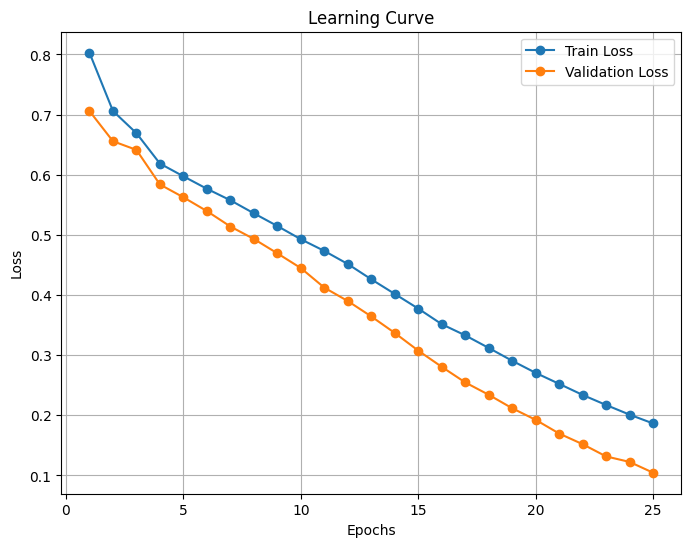

In [28]:
def plot_learning_curve(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    output_path = "learning_curve.png"
    plt.savefig(output_path, format='png', dpi=300)
    plt.show()


train_losses = [0.802893521592021, 0.7060485577285289, 0.6691135690510273, 
                0.6185770456790924, 0.5973929115086793, 0.5766452202200889, 
                0.5575537205040455, 0.5358725815564394, 0.5147300308793783, 
                0.4927599046230316, 0.4732972025871277, 0.45155345141142605,
                0.4261477880999446, 0.4018120840266347, 0.37739920149743555,
                0.35149034402519463, 0.3329180828407407, 0.3120179062411189,
                0.2906470487266779, 0.27054057178646324, 0.25226439246535304,
                0.23384463534876704, 0.21709124333783983, 0.2010833992511034,
                0.18640899186953902]
val_losses = [0.7059373706579208, 0.6557331832647324, 0.6413211541175843, 
              0.5838069107532501, 0.5624803940057754, 0.5395638505220414, 
              0.5139215791225433, 0.4931975585222244, 0.46935059237480165, 
              0.44478130161762236, 0.4122677685022354, 0.38999235510826114,
              0.3643782172203064, 0.33691601556539535, 0.30751774209737776,
              0.2805767132043839, 0.2546682589054108, 0.23411924237012863,
              0.2117019858658314, 0.19243190681934358, 0.1696506887078285,
              0.15192960026860236, 0.1316099673062563, 0.12244187784194946, 
              0.10449927558004857]
plot_learning_curve(train_losses, val_losses)


## Generate

In [29]:
from PIL import Image

# Đường dẫn thư mục chứa các tệp mô hình
model_path = '/kaggle/input/yolov8_gpt2_v20ep/pytorch/default/1'

# Tải mô hình VisionEncoderDecoder
model = VisionEncoderDecoderModel.from_pretrained(model_path, ignore_mismatched_sizes=True)
    
# Hàm để dự đoán caption cho ảnh
def predict_internet_caption(model, image_path, show_image=False):
    response = requests.get(image_path)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    # Đọc ảnh bằng OpenCV
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    # Chuyển đổi từ BGR (OpenCV) sang RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Sử dụng FeatureExtractorModel để trích xuất đặc trưng
    pixel_values = feature_extractor(image_rgb)
    
    output_ids = model.generate(
                pixel_values
                ,max_length=150
                ,min_length=10
                ,early_stopping=True
            )
    print(output_ids.shape)
    caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    if show_image == True:
        plt.imshow(image_rgb)
    return caption
# image_path = "http://images.cocodataset.org/val2017/000000399462.jpg"

# image_path = "http://images.cocodataset.org/train2017/000000129362.jpg"
image_path = "https://thuythithi.com/wp-content/uploads/2023/10/cu-gay-di-phan-xanh-nguyen-nhan-va-cach-dieu-tri2.jpg"
# print(predict_internet_caption(model, image_path, show_image=True))

In [30]:
# Hàm tải ảnh từ URL
def load_image(image_url):
    response = requests.get(image_url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb
# Hàm hiển thị ảnh và caption theo chiều dọc với kiểm tra từng ảnh
def display_images_vertical_layout_fixed(model, image_urls):
    total_images = len(image_urls)

    # Điều chỉnh kích thước từng hàng
    fig, axes = plt.subplots(total_images, 2, figsize=(8, 3 * total_images))  # Chiều cao giảm
    # fig.suptitle("Ảnh và Caption (Dọc)", fontsize=16, y=1.02)

    # Nếu chỉ có một ảnh, đảm bảo `axes` không phải là mảng
    if total_images == 1:
        axes = [axes]

    for i, image_url in enumerate(image_urls):
        try:
            # Tải ảnh và caption
            image_rgb = load_image(image_url)
            caption = predict_internet_caption(model, image_url)
            
            # Bên trái: hiển thị ảnh
            axes[i][0].imshow(image_rgb)
            axes[i][0].axis('off')  # Tắt viền
            
            # Bên phải: hiển thị caption
            axes[i][1].text(0.5, 0.5, caption, fontsize=12, ha='center', va='center', wrap=True)
            axes[i][1].axis('off')  # Tắt viền
        except Exception as e:
            print(f"Lỗi khi xử lý ảnh tại index {i}: {e}")
            # Bỏ qua ảnh bị lỗi, giữ ô trống
            axes[i][0].axis('off')
            axes[i][1].axis('off')

    # Điều chỉnh khoảng cách giữa các hàng
    plt.subplots_adjust(hspace=0.1)  # Giảm hspace để các dòng gần hơn
    plt.tight_layout()
    output_path = "test_picture.png"  # Đường dẫn tệp PNG
    plt.savefig(output_path, format='png', dpi=300)
    plt.show()


In [31]:
# Danh sách URL ảnh
image_urls = [
    "https://media.dolenglish.vn/PUBLIC/MEDIA/0f3179b4-23f7-4e0c-ad21-882339dd52ed.webp",
    "https://ecoparker.com/sites/default/files/di%20gi/xe-bus-hanoi-ecopark.jpg",
    "https://nhalouis.com/wp-content/uploads/2019/10/dien-tich-chuan-nha-ve-sinh.jpg",
]

# Hiển thị ảnh với bố cục dọc
# display_images_vertical_layout_fixed(model, image_urls)


In [32]:
# Danh sách URL ảnh
image_urls = [
    "http://116.118.50.253:9000/mlflow/user_images/image_20241110014605.jpg",
    "https://cdn.nguyenkimmall.com/images/companies/_1/Content/tin-tuc/gia-dung/4-yeu-to-giup-ban-so-huu-mau-nha-bep-dep-tien-dung-h1.jpg",
    "https://thanhnien.mediacdn.vn/Uploaded/quangtuyen/2022_04_22/anh-5-1381.jpg",
]

# Hiển thị ảnh với bố cục dọc
# display_images_vertical_layout_fixed(model, image_urls)

In [33]:
# Danh sách URL ảnh
image_urls = [
    "https://i0.wp.com/noithatanthinhphat.vn/wp-content/uploads/2022/08/tao-dang-chup-anh-o-quan-cafe-1-%40truonghoang.maianh.jpg?resize=700%2C875&ssl=1",
    "https://todocar.vn/public/upload/images/article/2021/01/Kinh-nghiem-can-duong-xac-dinh-vi-tri-xe-o-to.jpg",
    "https://images2.thanhnien.vn/528068263637045248/2023/2/15/bong-da-sv-2bb-16764458055041936602631.jpg",
    "https://www.hrjohnsonindia.com/assets/images/blog/fainer-3d.jpg",
    "https://danviet.mediacdn.vn/upload/2-2018/images/2018-04-22/17-1524365344-width650height453.jpg",
    "https://cdn.tgdd.vn/Files/2022/03/31/1423196/moi-dieu-can-biet-cho-con-cach-nuoi-cham-soc-va-huan-luyen-202203311033114159.jpg",
    "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRYbTEgn3hShJTFzmlyyEV7iAGHc9T7RGtkeA&s",
    "https://bizweb.dktcdn.net/thumb/grande/100/169/223/products/0dd2cdea4ced7e2be5b80a21e5529f99.jpg?v=1646544840683",
    "https://discoverymood.com/wp-content/uploads/2020/04/Mental-Strong-Women-min-480x340.jpg",
]

# Hiển thị ảnh với bố cục dọc
# display_images_vertical_layout_fixed(model, image_urls)

In [34]:
# # Danh sách URL ảnh
# image_urls = [
#     # "http://116.118.50.253:9000/mlflow/user_images/image_20241118052418.jpg",
#     "http://116.118.50.253:9000/mlflow/user_images/image_20241125104719.jpg",
#     "http://116.118.50.253:9000/mlflow/user_images/image_20241125081856.jpg",
#     "http://116.118.50.253:9000/mlflow/user_images/image_20241110014605.jpg"
#     # "http://116.118.50.253:9000/mlflow/user_images/image_20241110100519.jpg",
#     # "http://116.118.50.253:9000/mlflow/user_images/image_20241113092619.jpg"
# ]

# # Hiển thị ảnh với bố cục dọc
# display_images_vertical_layout_fixed(model, image_urls)

torch.Size([1, 94])
torch.Size([1, 138])
torch.Size([1, 97])


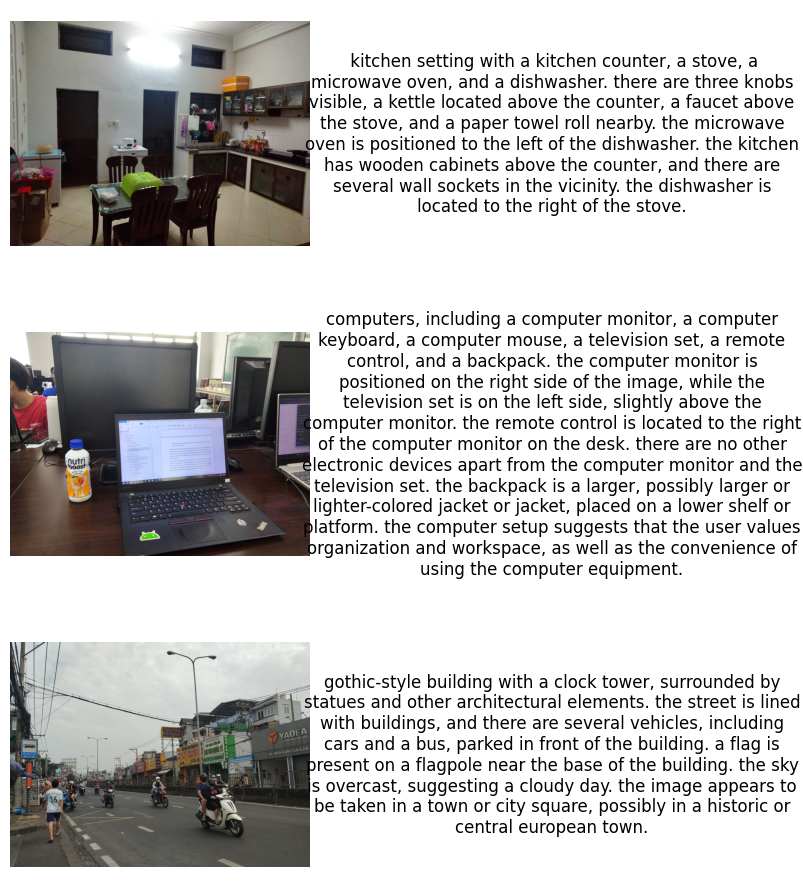

In [37]:
# Danh sách URL ảnh
image_urls = [
    # "http://116.118.50.253:9000/mlflow/user_images/image_20241118052418.jpg",
    "http://116.118.50.253:9000/mlflow/user_images/image_20241125104719.jpg",
    "http://116.118.50.253:9000/mlflow/user_images/image_20241125081856.jpg",
    "http://116.118.50.253:9000/mlflow/user_images/image_20241110014605.jpg",
    # "http://116.118.50.253:9000/mlflow/user_images/image_20241110100519.jpg"
]

# Hiển thị ảnh với bố cục dọc
display_images_vertical_layout_fixed(model, image_urls)

# Evaluate

In [36]:
# from PIL import Image

# # Đường dẫn thư mục chứa các tệp mô hình
# model_path = '/kaggle/input/yolov8_gpt2_v15ep/pytorch/default/1'

# # Tải mô hình VisionEncoderDecoder
# model = VisionEncoderDecoderModel.from_pretrained(model_path, ignore_mismatched_sizes=True)

# # Hàm để dự đoán caption cho ảnh
# def predict_internet_caption(model, image_path):
#     response = requests.get(image_path)
#     image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
#     # Đọc ảnh bằng OpenCV
#     image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
#     # Chuyển đổi từ BGR (OpenCV) sang RGB
#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     # Sử dụng FeatureExtractorModel để trích xuất đặc trưng
#     pixel_values = feature_extractor(image_rgb)
    
#     output_ids = model.generate(
#                 pixel_values
#                 ,max_length=150 
#                 ,min_length=10
#                 ,early_stopping=True
#             )
    
#     caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
#     plt.imshow(image_rgb)
#     return caption

In [37]:
# # validate với test data
# actual, predicted = {}, {}

# # Duyệt qua từng ảnh trong tập test
# for url in tqdm(test_urls):
#     # Lấy actual caption từ cột 'caption'
#     caption_series = captions['caption'][captions.url == url]
#     if caption_series.empty:  # Kiểm tra nếu không có dữ liệu
#         raise ValueError(f"Không tìm thấy caption cho URL: {url}")
    
#     caption = caption_series.iloc[0]
#     caption = caption_preprocess(caption)
#     image_url = url
    
#     # Dự đoán caption cho ảnh từ URL
#     y_pred = predict_internet_caption(model, image_url)
    
#     # Thêm các kết quả vào từ điển
#     # Sử dụng chỉ số url làm khóa
#     actual[url] = [caption]  # Actual captions là danh sách chuỗi
#     predicted[url] = [y_pred]  # Predicted captions là danh sách chứa một chuỗi

In [38]:
# # # Đường dẫn đến file để lưu kết quả
# output_file = "caption_results_15ep.json"

# # Tạo cấu trúc dữ liệu cần lưu
# results = {
#     "actual": actual,
#     "predicted": predicted
# }

# # Ghi dữ liệu vào file JSON
# with open(output_file, "w", encoding="utf-8") as f:
#     json.dump(results, f, ensure_ascii=False, indent=4)

# print(f"Kết quả đã được lưu vào file: {output_file}")


## Evaluate

In [39]:
# Đọc dữ liệu từ file JSON
def load_predict_result(output_file):
    with open(output_file, "r", encoding="utf-8") as f:
        loaded_results = json.load(f)

    actual = loaded_results["actual"]
    predicted = loaded_results["predicted"]
    print("Dữ liệu đã được tải lại thành công!")
    return actual, predicted

In [40]:
!pip install rouge-score -q
!pip install pycocoevalcap -q

In [41]:
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor

In [42]:
# Tính BLEU scores
def bleu_score(actual, predicted):
    bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0))
    bleu_4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    return bleu_1, bleu_2, bleu_3, bleu_4

In [43]:
def bleu_score_avg(actual, predicted):
    # min_key = int(min(actual.keys()))
    # max_key = int(max(actual.keys()))
    
    # Khởi tạo danh sách để lưu BLEU score của tất cả các cặp
    bleu_1_scores = []
    bleu_2_scores = []
    bleu_3_scores = []
    bleu_4_scores = []
    
    for i in actual.keys():
        actual_caption = actual.get(str(i), [])
        predicted_caption = predicted.get(str(i), [])

        if actual_caption and predicted_caption:
            bleu_1, bleu_2, bleu_3, bleu_4 = bleu_score(actual_caption, predicted_caption)
            # Lưu các điểm BLEU vào danh sách
            bleu_1_scores.append(bleu_1)
            bleu_2_scores.append(bleu_2)
            bleu_3_scores.append(bleu_3)
            bleu_4_scores.append(bleu_4)
    
    # Tính trung bình của các BLEU score
    average_bleu_1 = sum(bleu_1_scores) / len(bleu_1_scores)
    average_bleu_2 = sum(bleu_2_scores) / len(bleu_2_scores)
    average_bleu_3 = sum(bleu_3_scores) / len(bleu_3_scores)
    average_bleu_4 = sum(bleu_4_scores) / len(bleu_4_scores)

    return average_bleu_1, average_bleu_2, average_bleu_3, average_bleu_4


In [44]:
from rouge_score import rouge_scorer

def rouge_score(actual, predicted):
    # Tạo scorer tính các loại ROUGE hợp lệ
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Lưu điểm cho từng loại ROUGE
    rouge1_scores, rouge2_scores, rougeL_scores = [], [], []

    # Tính điểm ROUGE cho từng cặp câu
    for index in actual.keys():
        actual_caption = " ".join(actual[index])  # Ghép các từ thành chuỗi
        predicted_caption = " ".join(predicted[index])  # Ghép các từ thành chuỗi

        # Tính điểm cho cặp hiện tại
        scores = scorer.score(actual_caption, predicted_caption)

        # Lưu điểm F1 cho từng loại
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    # Tính điểm trung bình cho từng loại ROUGE
    rouge1_avg = sum(rouge1_scores) / len(rouge1_scores)
    rouge2_avg = sum(rouge2_scores) / len(rouge2_scores)
    rougeL_avg = sum(rougeL_scores) / len(rougeL_scores)

    # Trả về ba giá trị ROUGE1, ROUGE2, ROUGEL
    return rouge1_avg, rouge2_avg, rougeL_avg


In [45]:
def evaluate(caption_result_file_name='caption_results_10ep_100.json'):
    actual, predicted = load_predict_result(caption_result_file_name)

    # Do sai datatype nên sử dụng đoạn này. Sau điều chỉnh save json lại, không cần dùng
    for key, value in actual.items():
        if isinstance(value, str):  # Nếu là string
            actual[key] = [value]  # Chuyển thành list chứa string

    
    bleu_1, bleu_2, bleu_3, bleu_4 = bleu_score_avg(actual, predicted)
    
    rouge1, rouge2, rougeL = rouge_score(actual, predicted)

    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(actual, predicted)
    
    meteor_scorer = Meteor()
    meteor_score, _ = meteor_scorer.compute_score(actual, predicted)
    
    evaluation_scores = {
            'bleu_1': bleu_1,
            'bleu_2': bleu_2,
            'bleu_3': bleu_3,
            'bleu_4': bleu_4,
            'rouge1': rouge1,
            'rouge2': rouge2,
            'rougeL': rougeL,
            'cider_score': cider_score,
            'meteor_score': meteor_score
        }
    return evaluation_scores

In [46]:
import os
import pandas as pd

# List để lưu kết quả
all_results = []
epoch_range = ['08', '15', '20', '25']

# Vòng lặp qua các file JSON
for i in epoch_range:
    # Tạo đường dẫn file
    file_name_1 = f"/kaggle/input/result-{i}ep/caption_results_{i}ep.json"
    file_name_2 = f"/kaggle/working/caption_results_{i}ep.json"
    
    # Kiểm tra đường dẫn file tồn tại
    if os.path.exists(file_name_1):
        file_name = file_name_1
    elif os.path.exists(file_name_2):
        file_name = file_name_2
    else:
        print(f"File not found for epoch {i}")
        continue  # Nếu không file nào tồn tại, bỏ qua

    # Gọi hàm evaluate_scores để lấy kết quả cho từng file
    evaluation_scores = evaluate(file_name)
    
    # Thêm số lượng epoch vào kết quả
    evaluation_scores['epoch'] = i
    
    # Thêm kết quả vào list
    all_results.append(evaluation_scores)

# Chuyển danh sách kết quả thành DataFrame
df_scores = pd.DataFrame(all_results)

output_csv_path = "/kaggle/working/evaluation_results.csv"
df_scores.to_csv(output_csv_path, index=False)

# In DataFrame để kiểm tra
print(df_scores)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Dữ liệu đã được tải lại thành công!


/opt/conda/lib/python3.10/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


     bleu_1    bleu_2    bleu_3    bleu_4    rouge1    rouge2    rougeL  \
0  0.055583  0.234040  0.382824  0.482866  0.363404  0.098923  0.231551   
1  0.057481  0.238082  0.387230  0.487099  0.381247  0.102808  0.233227   
2  0.053325  0.230630  0.379666  0.480088  0.497466  0.205504  0.309964   
3  0.058715  0.240533  0.389830  0.489565  0.377812  0.100028  0.233870   

   cider_score  meteor_score epoch  
0     0.065689      0.124459    08  
1     0.074017      0.129871    15  
2     0.003058      0.162669    20  
3     0.069755      0.127927    25  


In [47]:
# import matplotlib.pyplot as plt

# # Lựa chọn các cột cần vẽ
# bleu_metrics = ['bleu_1', 'bleu_2', 'bleu_3', 'bleu_4']
# rouge_metrics = ['rouge1', 'rouge2', 'rougeL']
# cider_meteor_metrics = ['cider_score', 'meteor_score']

# # Vẽ biểu đồ cho từng chỉ số
# def plot_evaluate_score(metrics, title="title"):
#     for metric in metrics:
#         plt.plot(df_scores['epoch'], df_scores[metric], marker='o', label=metric)
    
#     plt.xlabel('Epoch')
#     plt.ylabel('Score')
#     plt.title(title)
#     plt.legend()
#     plt.grid()
#     plt.show()

# plot_evaluate_score(bleu_metrics, "BLEU Score Over Epochs")
# plot_evaluate_score(rouge_metrics, "ROUGE score Over Epochs")
# plot_evaluate_score(cider_meteor_metrics, "CIDEr - METEOR Over Epochs")


In [48]:
# import matplotlib.pyplot as plt

# # Lựa chọn các cột cần vẽ
# bleu_metrics = ['bleu_1', 'bleu_2', 'bleu_3', 'bleu_4']
# rouge_metrics = ['rouge1', 'rouge2', 'rougeL']
# cider_meteor_metrics = ['cider_score', 'meteor_score']

# # Hàm vẽ các chỉ số
# def plot_evaluate_scores_subplot(metrics, title, ax):
#     for metric in metrics:
#         ax.plot(df_scores['epoch'], df_scores[metric], marker='o', label=metric)
    
#     ax.set_xlabel('Epoch')
#     ax.set_ylabel('Score')
#     ax.set_title(title)
#     ax.legend()
#     ax.grid()

# # Tạo biểu đồ với subplots
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 hàng, 3 cột, kích thước 18x5

# # Vẽ từng biểu đồ trên các trục riêng
# plot_evaluate_scores_subplot(bleu_metrics, "BLEU Score Over Epochs", axes[0])
# plot_evaluate_scores_subplot(rouge_metrics, "ROUGE Score Over Epochs", axes[1])
# plot_evaluate_scores_subplot(cider_meteor_metrics, "CIDEr - METEOR Over Epochs", axes[2])

# # Hiển thị biểu đồ
# plt.tight_layout()
# plt.show()

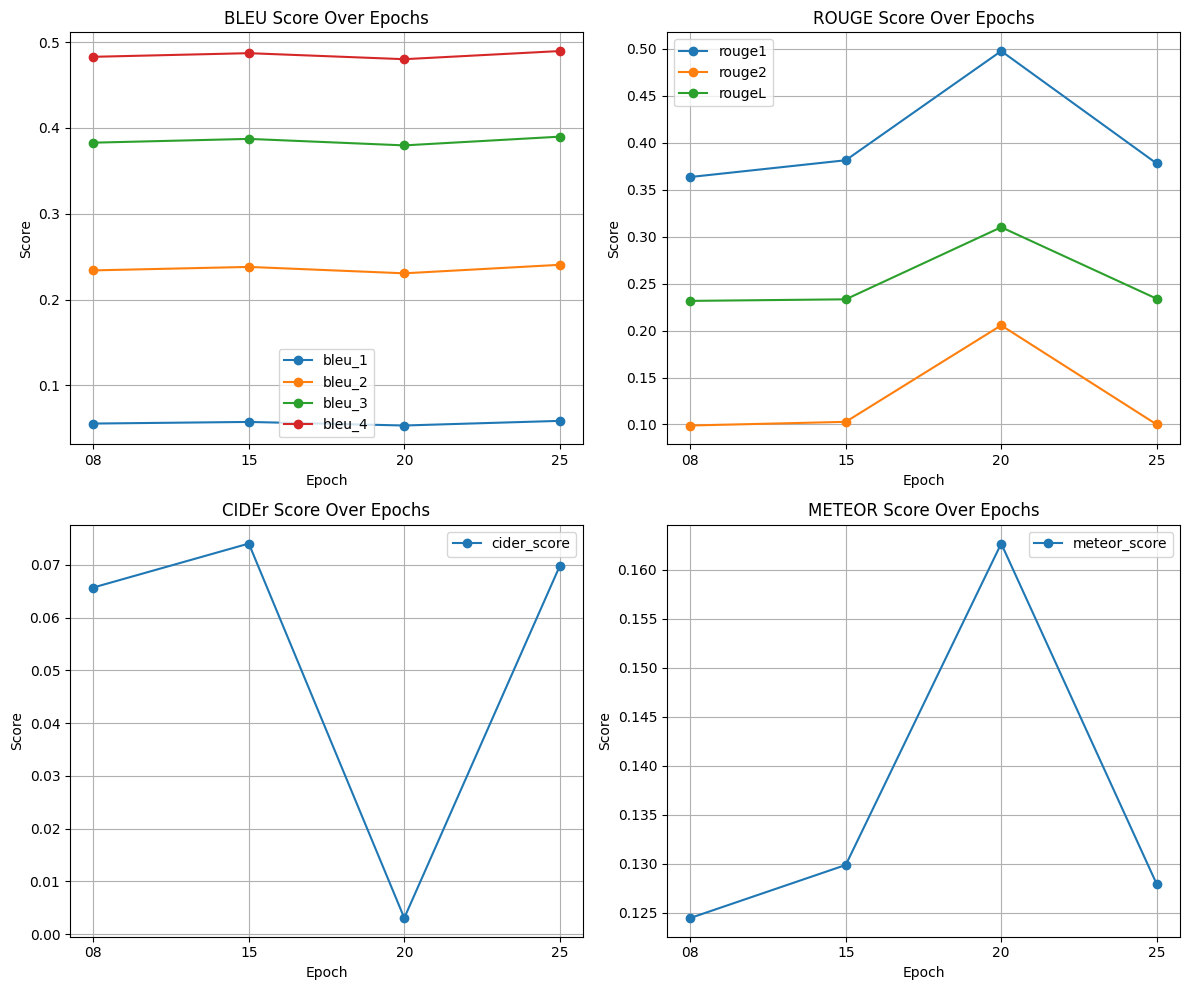

In [49]:
import matplotlib.pyplot as plt

# Lựa chọn các cột cần vẽ
bleu_metrics = ['bleu_1', 'bleu_2', 'bleu_3', 'bleu_4']
rouge_metrics = ['rouge1', 'rouge2', 'rougeL']
cider_metrics = ['cider_score']
meteor_metrics = ['meteor_score']

# Hàm vẽ các chỉ số
def plot_evaluate_scores_subplot(metrics, title, ax):
    for metric in metrics:
        ax.plot(df_scores['epoch'], df_scores[metric], marker='o', label=metric)
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.legend()
    ax.grid()

# Tạo biểu đồ với subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 hàng, 2 cột, kích thước 12x10

# Vẽ từng biểu đồ trên các trục riêng
plot_evaluate_scores_subplot(bleu_metrics, "BLEU Score Over Epochs", axes[0][0])
plot_evaluate_scores_subplot(rouge_metrics, "ROUGE Score Over Epochs", axes[0][1])
plot_evaluate_scores_subplot(cider_metrics, "CIDEr Score Over Epochs", axes[1][0])
plot_evaluate_scores_subplot(meteor_metrics, "METEOR Score Over Epochs", axes[1][1])

# Điều chỉnh khoảng cách
plt.tight_layout()

# Lưu hình ảnh
output_path = "evaluation_scores.png"  # Đường dẫn tệp PNG
plt.savefig(output_path, format='png', dpi=300)

# Hiển thị biểu đồ (tùy chọn)
plt.show()
